## Bounding Box model

The concept and data is from this kaggle kernel: [Bounding Box Model](https://www.kaggle.com/martinpiotte/bounding-box-model)

Also from this notebook: [github](https://github.com/radekosmulski/whale/blob/master/fluke_detection_redux.ipynb)

The idea is standardize the image focus and to make it easier for the classification model to recognize whale id. The data provided was manually created by placing landmarks on the whale tail and using the maximum value of them to create the the cropping location. 

There are 1200 bounding box samples. The data is not from this competition but from the [playground](https://www.kaggle.com/c/whale-categorization-playground) 

Make sure to make to upgrade your fastai. I was using 1.0.38 which was giving errors when creating the databunch until it was update to 1.0.41.

TO DO:
    * Export the model so one can simply just run the model rather than train

In [1]:
import fastai
from fastai import *
from fastai.vision import *
print(fastai.__version__)

verbose = False  # print out extra details?

# import matplotlib.patches.Path
from matplotlib.patches import Rectangle
%matplotlib inline

import json
import warnings
warnings.filterwarnings('ignore')

1.0.41


In [2]:
# global setting
data_fp = Path('data')
data_train = data_fp/'train'
data_playground = data_fp/'train_playground'
data_test = data_fp/'test'
crop_fp = data_fp/'cropping.txt'

In [3]:
bs = 4
num_workers = 3  # set to zero when using kaggle kernel. It crashing the kernel if not
sz = 224 ## resize images

## Look into the cropping dataset

In [4]:
with open(crop_fp, 'rt') as f:
    crop_ls = [r.split(',') for r in f.read().split('\n') if len(r.split(',')) > 1]

In [5]:
crop_data = [(img, [(int(coords[i]), int(coords[i+1])) for i in range(0, len(coords), 2)]) 
                                                         for img, *coords in crop_ls]

set([len(r[1]) for r in crop_data])

{4, 5, 6, 7, 8, 9, 10, 11}

There are varying number of point pairs for each image ranging from 4 to 11 points. 

Each step converting data into the right format to use
```python
    text file: "image_filename, x1, y1, x2, x3, ... \n .....]
    crop_ls: [image_filename, x1, y1, x2, x3, ...]
    crop_data: [image_filename, [(x1, y1), (x2, y2), ..]]
```

In [6]:
crop_data[0]

('88532e70.jpg',
 [(195, 293),
  (269, 115),
  (868, 158),
  (888, 170),
  (641, 496),
  (512, 546),
  (321, 524)])

In [7]:
def get_bbox(coords):
    x, y = [x for x,_ in coords], [y for _,y in coords]
    xmin, xmax= min(x), max(x)
    ymin, ymax = min(y), max(y)
    # lower left corner, width and height
    return xmin, ymin, xmax-xmin, ymax-ymin

def draw_bbox(box):
    return Rectangle((box[0], box[1]), box[2], box[3],
                     linewidth=1, edgecolor='r', facecolor='none')

def img_bbox(data):
    img = PIL.Image.open(data_playground/data[0])
    _, ax = plt.subplots(figsize=(10,10))
    ax.imshow(img)
    ax.axis('off')
    ax.scatter([x for x,_ in data[1]], [y for _,y in data[1]], marker='o', c='r')
    ax.add_patch(draw_bbox(get_bbox(data[1])))
    ax.set_title(data[0])
    plt.show()

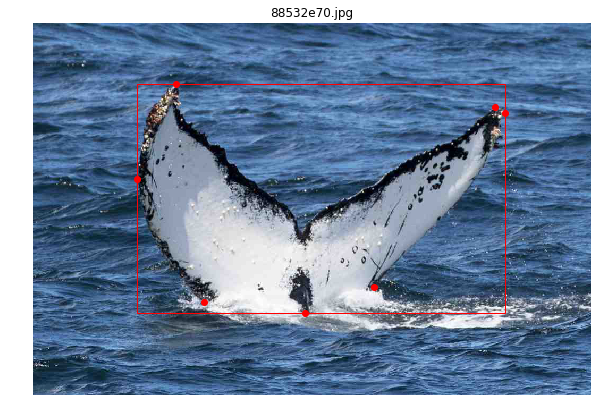

In [8]:
# bbox is created from the landmarks
img_bbox(crop_data[0])

## Convert data into Coco dataset format and then to fastai format


**Coco format**
```json
{
    "categories": [
        {"id": 0, "name": "whale"},
        {"id": 1, "name": "placeholder"}
    ],
    "images": [
        {"id": 1000, "file_name": "whale1.jpg"},
        {"id": 1001, "file_name": "whale2.jpg"}
    ],
    "annotations": [
        {"image_id": 1000, "bbox": [x, y, width, height], "category_id": 0},
        {"image_id": 1001, "bbox": [x, y, width, height], "category_id": 0}
    ]
}
```

**Fastai Format** for multiple objects in an image
```python
[
    [image_fn, image_fn],
    [[
        [[[y_upper_left, x_upper_left, y_lower_right, x_lower_right], 
          [[y_upper_left, x_upper_left, y_lower_right, x_lower_right]], 
         ['whale', 'whale']],
        [[[[y_upper_left, x_upper_left, y_lower_right, x_lower_right], 
          [[y_upper_left, x_upper_left, y_lower_right, x_lower_right]], 
         ['whale', 'whale']]
    ]]  
]
```

In [9]:
images, annotations = [], []
for i, v in enumerate(crop_data, start=1000):
    images.append({"id": i, "file_name": v[0]})
    annotations.append({"image_id": i, "bbox": get_bbox(v[1]), "category_id": 0})

categories = [{"id": 0, "name": "whale"}]

coco_whale = {"categories": categories,
              "images": images,
              "annotations": annotations}

with open("data/coco_whale.json", "w+") as f:
    json.dump(obj=coco_whale, fp=f, indent=4)

In [10]:
del images, annotations, categories, coco_whale, i, v, crop_data, crop_fp, crop_ls

## Testing that the conversion was done corrected

In [11]:
tmp_images, tmp_lbl_bbox = get_annotations('data/coco_whale.json')
len(tmp_images)

1200

coco_dataset format is (x, y, width, height)

fastai expect (y_upper_left, x_upper_left, y_lower_right, x_lower_right) with the origin in the upper left hand corner of the image. 

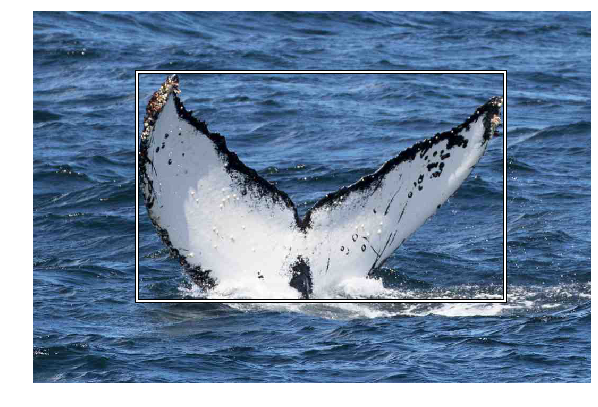

In [12]:
img = open_image(Path('data/train_playground')/tmp_images[0])
bbox = ImageBBox.create(*img.size, tmp_lbl_bbox[0][0])
img.show(y=bbox, figsize=(10,10))

In [13]:
del tmp_images, tmp_lbl_bbox, img, bbox

## Create DataBunch with Coco Format

In [14]:
images, lbl_bbox = get_annotations('data/coco_whale.json')
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o: img2bbox[Path(o).name]

In [15]:
tfm = get_transforms(flip_vert=False, 
                     # doesn't make to have upside down tails
                     max_rotate=0.3)
                     # rotating too much will cause the bbox to be super large and not accurate
if verbose: tfm  # show the list of transformation

In [16]:
data = (ObjectItemList.from_df(pd.DataFrame(data=images), path='data/train_playground')
        .random_split_by_pct(seed=52)                          
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func)
        #How to find the labels? -> use get_y_func
        .transform(get_transforms(), 
                   tfm_y= True, 
                   size=sz, 
                   resize_method=ResizeMethod.SQUISH,
                   padding_mode='border')
        #Data augmentation? -> Standard transforms with tfm_y=True
        .databunch(bs=bs, collate_fn=bb_pad_collate, num_workers=num_workers))   
        #Finally we convert to a DataBunch and we use bb_pad_collate

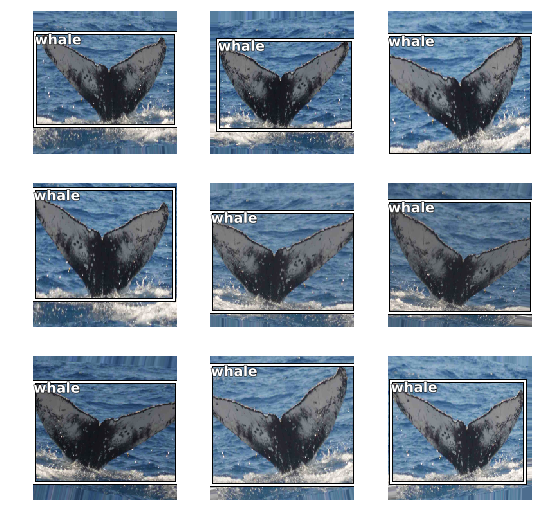

In [17]:
idx = 26
fig, axes = plt.subplots(3,3, figsize=(9,9))
for i, ax in enumerate(axes.flat):
    img = data.train_ds[idx]
    # image is augmented each time it is retrived
    img[0].show(y=img[1], ax=ax)

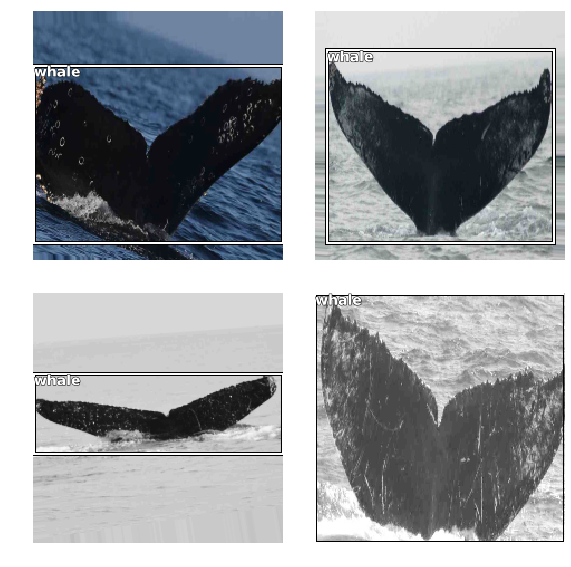

In [18]:
data.show_batch(rows=2)

## Training

In [24]:
def loss_func(preds, targs, class_idx, **kwargs):
    return nn.L1Loss()(preds, targs.squeeze())

In [25]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,4))
learn = create_cnn(data=data, arch=models.resnet18, pretrained=True, custom_head=head_reg4)
learn.loss_func = loss_func

In [26]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [16, 64, 112, 112]   9408       False     
______________________________________________________________________
BatchNorm2d          [16, 64, 112, 112]   128        True      
______________________________________________________________________
ReLU                 [16, 64, 112, 112]   0          False     
______________________________________________________________________
MaxPool2d            [16, 64, 56, 56]     0          False     
______________________________________________________________________
Conv2d               [16, 64, 56, 56]     36864      False     
______________________________________________________________________
BatchNorm2d          [16, 64, 56, 56]     128        True      
______________________________________________________________________
ReLU                 [16, 64, 56, 56]     0          False     
______________________________________________________________

In [27]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


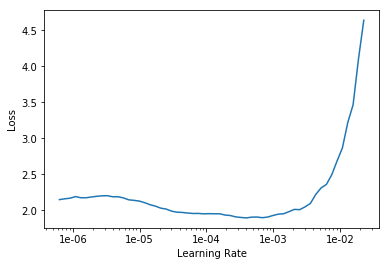

In [28]:
learn.recorder.plot()

In [21]:
%debug

> c:\users\boki\anaconda3\lib\site-packages\torch\nn\modules\module.py(489)__call__()
    487             result = self._slow_forward(*input, **kwargs)
    488         else:
--> 489             result = self.forward(*input, **kwargs)
    490         for hook in self._forward_hooks.values():
    491             hook_result = hook(self, input, result)



ipdb>  type(input)


<class 'tuple'>


ipdb>  len(input)


3


ipdb>  type(input[0])


<class 'torch.Tensor'>


ipdb>  type(self)


<class 'torch.nn.modules.loss.L1Loss'>


ipdb>  type(kwargs)


<class 'dict'>


ipdb>  len(kwargs)


0


ipdb>  kwargs


{}


ipdb>  nn.loss.L1Loss().forward


*** NameError: name 'nn' is not defined


ipdb>  nn.L1Loss().forward


*** NameError: name 'nn' is not defined


ipdb>  exit


In [23]:
%debug

> c:\users\boki\anaconda3\lib\site-packages\torch\nn\modules\module.py(489)__call__()
    487             result = self._slow_forward(*input, **kwargs)
    488         else:
--> 489             result = self.forward(*input, **kwargs)
    490         for hook in self._forward_hooks.values():
    491             hook_result = hook(self, input, result)



ipdb>  input[0].shape


torch.Size([16, 4])


ipdb>  input[1].shape


torch.Size([16, 1, 4])


ipdb>  input[2].shape


torch.Size([16, 1])


ipdb>  exit


In [ ]:
L1Lo

In [ ]:
learn.fit(1)

In [ ]:
## need to create a custom head
## need to use l1 loss


In [ ]:
URLs.COCO_TINY

In [ ]:
coco = untar_data(URLs.COCO_TINY)
images, lbl_bbox = get_annotations(coco/'train.json')
img2bbox = dict(zip(images, lbl_bbox))
get_y_func2 = lambda o:img2bbox[o.name]

# def get_y_func2(o):
#     print(o, type(o))
#     return img2bbox[o.name]

In [ ]:
data2 = (ObjectItemList.from_folder(coco)
        #Where are the images? -> in coco
        .random_split_by_pct()                          
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func2)
        #How to find the labels? -> use get_y_func
        .transform(get_transforms(), tfm_y=True)
        #Data augmentation? -> Standard transforms with tfm_y=True
        .databunch(bs=16, collate_fn=bb_pad_collate, num_workers=0))   
        #Finally we convert to a DataBunch and we use bb_pad_collate

In [ ]:
data2.show_batch(rows=2, figsize=(6,6))

In [ ]:
data2.c

In [ ]:
data2.classes